# Load Into CNN Stock Prediction G-Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd "drive/MyDrive/CNN Stock Prediction"

/content/drive/MyDrive/CNN Stock Prediction


In [ ]:
!ls data/

4_best_model_keras.h5  cifar10			 IBM_kbest_selected_features.csv  test_model.png
4_model.png	       Eric_best_model_keras.h5  labeled
adjusted	       features			 labeled_indicators
animals		       historical		 split


# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# optional pandas display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

# Load Data

In [ ]:
from keras.datasets import cifar10
from skimage.transform import resize

In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

## Subset CIFAR Classes

In [ ]:
bird_index = np.where(y_train.reshape(-1) == 2)
X_train_class_0 = X_train[bird_index]
y_train_class_0 = y_train[bird_index]

dog_index = np.where(y_train.reshape(-1) == 5)
X_train_class_1 = X_train[dog_index]
y_train_class_1 = y_train[dog_index]

horse_index = np.where(y_train.reshape(-1) == 7)
X_train_class_2 = X_train[horse_index]
y_train_class_2 = y_train[horse_index]

X_train_animal = np.concatenate((X_train_class_0, X_train_class_1, X_train_class_2))
y_train_animal = np.concatenate((y_train_class_0, y_train_class_1, y_train_class_2)).reshape(-1,1)

In [ ]:
bird_test_index = np.where(y_test.reshape(-1) == 2)
X_test_class_0 = X_test[bird_test_index]
y_test_class_0 = y_test[bird_test_index]

dog_test_index = np.where(y_test.reshape(-1) == 5)
X_test_class_1 = X_test[dog_test_index]
y_test_class_1 = y_test[dog_test_index]

horse_test_index = np.where(y_test.reshape(-1) == 7)
X_test_class_2 = X_test[horse_test_index]
y_test_class_2 = y_test[horse_test_index]

X_test_animal = np.concatenate((X_test_class_0, X_test_class_1, X_test_class_2))
y_test_animal = np.concatenate((y_test_class_0, y_test_class_1, y_test_class_2)).reshape(-1,1)

In [ ]:
print(f'X train Shape: {X_train_animal.shape}, y train shape: {y_train_animal.shape}')
print(f'X test Shape: {X_test_animal.shape}, y test shape: {y_test_animal.shape}')

X train Shape: (15000, 32, 32, 3), y train shape: (15000, 1)
X test Shape: (3000, 32, 32, 3), y test shape: (3000, 1)


In [ ]:
pd.DataFrame(y_train_animal).value_counts()

2    5000
5    5000
7    5000
Name: count, dtype: int64

# Data Preprocessing

In [ ]:
# helper function to plot dataset image
def plot_img(img, i):
  plt.subplot(331 + i)
  # plot raw pixel data
  plt.imshow(img)

  plt.show()

original CIFAR10 image


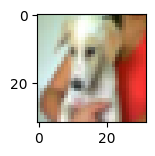

shape after averaging 3 layers: (32, 32)


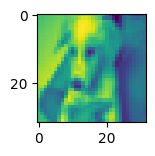

shape after resizing and adding single channel: (15, 15, 1)


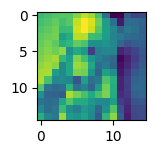

In [ ]:
import random
from random import sample

img_index = random.randint(0, 15000)

print('original CIFAR10 image')
ex = X_train_animal[img_index]
plot_img(ex, 0)

# average RGB channels into one channel (grayscale)
ex = np.mean(ex, axis=-1)
print(f'shape after averaging 3 layers: {ex.shape}')
plot_img(ex, 0)

# resize image to 15x15
new_shape = (15, 15)
X_resized = np.zeros((ex.shape[0], *new_shape))
X_resized = resize(ex, new_shape)

# add single channel
X_resized = np.expand_dims(X_resized, axis=-1)
print(f'shape after resizing and adding single channel: {X_resized.shape}')

plot_img(X_resized, 0)

## Process Single Channel Images

### Average RGB Layer
Averages three layers of images in CIFAR10 data set into one layer

In [ ]:
X_train_gray = np.mean(X_train_animal, axis=-1)
X_test_gray = np.mean(X_test_animal, axis=-1)
print(f'X train shape: {X_train_gray.shape}')
print(f'X test shape: {X_test_gray.shape}')

X train shape: (15000, 32, 32)
X test shape: (3000, 32, 32)


### Resize Images
Resize 32x32 images to 15x15 for CNN input layer

In [ ]:
# resize image to 15x15
new_shape = (15, 15)
X_train_resized = np.zeros((X_train_gray.shape[0], *new_shape))
X_test_resized = np.zeros((X_test_gray.shape[0], *new_shape))

# reshaping
for i in range(X_train_gray.shape[0]):
  X_train_resized[i] = resize(X_train_gray[i], new_shape)

for i in range(X_test_gray.shape[0]):
  X_test_resized[i] = resize(X_test_gray[i], new_shape)

# add single channel
X_train_single_final = X_train_resized
X_test_single_final = X_test_resized

print(f'X train shape: {X_train_single_final.shape}')
print(f'X train shape: {X_test_single_final.shape}')

X train shape: (15000, 15, 15)
X train shape: (3000, 15, 15)


## Process RGB Images

In [ ]:
# resize image to 15x15
new_shape = (15, 15, 3)
X_train_rgb_resized = np.zeros((X_train_animal.shape[0], *new_shape))
X_test_rgb_resized = np.zeros((X_test_animal.shape[0], *new_shape))

# reshaping
for i in range(X_train_animal.shape[0]):
  X_train_rgb_resized[i] = resize(X_train_animal[i], new_shape)

for i in range(X_test_animal.shape[0]):
  X_test_rgb_resized[i] = resize(X_test_animal[i], new_shape)

# add single channel
X_train_final = X_train_rgb_resized
X_test_final = X_test_rgb_resized

print(f'X train shape: {X_train_final.shape}')
print(f'X train shape: {X_test_final.shape}')

X train shape: (15000, 15, 15, 3)
X train shape: (3000, 15, 15, 3)


## Show Images

Original CIFAR10 Images: (32, 32, 3)


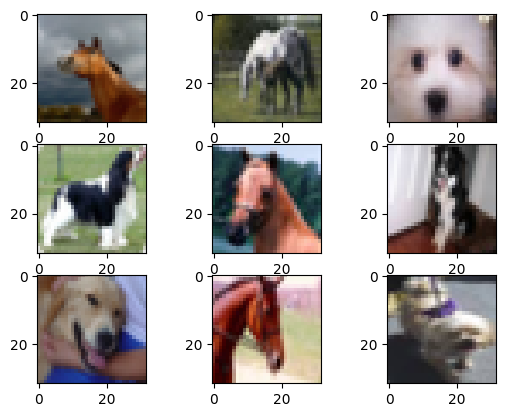

NameError: name 'X_train_single_final' is not defined

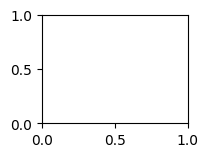

In [ ]:
# plot 9 random images
rand_img_ind = sample(range(0, 15000),9)

print(f"Original CIFAR10 Images: {X_train_animal[0].shape}")
for ind in zip(range(9), rand_img_ind):
	plt.subplot(330 + 1 + ind[0])
	# plot raw pixel data
	plt.imshow(X_train_animal[ind[1]])

plt.show()

for ind in zip(range(9), rand_img_ind):
	plt.subplot(330 + 1 + ind[0])
	# plot raw pixel data
	plt.imshow(X_train_single_final[ind[1]])

print(f"Processed CIFAR10 Images: {X_train_single_final[0].shape}")
plt.show()

Original CIFAR10 Images: (32, 32, 3)


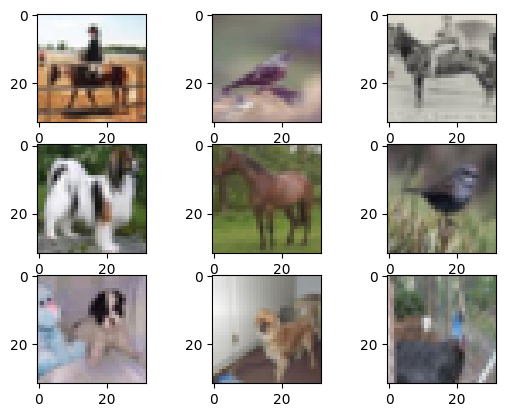

Processed CIFAR10 Images: (15, 15, 3)


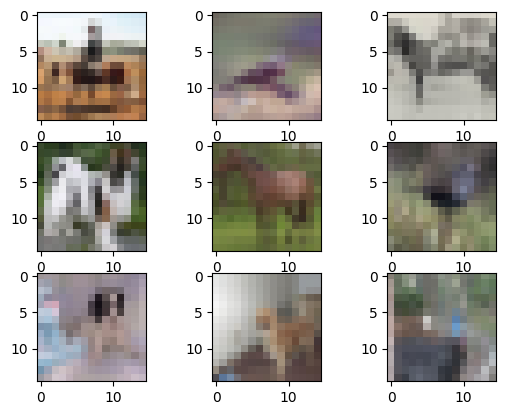

In [ ]:
# plot 9 random images
rand_img_ind = sample(range(0, 15000),9)

print(f"Original CIFAR10 Images: {X_train_animal[0].shape}")
for ind in zip(range(9), rand_img_ind):
	plt.subplot(330 + 1 + ind[0])
	# plot raw pixel data
	plt.imshow(X_train_animal[ind[1]])

plt.show()

for ind in zip(range(9), rand_img_ind):
	plt.subplot(330 + 1 + ind[0])
	# plot raw pixel data
	plt.imshow(X_train_final[ind[1]])

print(f"Processed CIFAR10 Images: {X_train_final[0].shape}")
plt.show()

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Training and Cross Validation Data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_final, y_train_animal, train_size=0.8,
                                                    test_size=0.2, random_state=2, shuffle=True,
                                                    stratify=y_train_animal)

In [ ]:
print(f"X_train shape: {X_train_split.shape}")
print(f"y_train shape: {y_train_split.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (12000, 15, 15, 3)
y_train shape: (12000, 1)
X_val shape: (3000, 15, 15, 3)
y_val shape: (3000, 1)


# Normalize and Encode Data

## Normalize Images

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Encode Labels

In [ ]:
# Define dictionary for reassigning class labels
labels = {2: 0, 5: 1, 7: 2}

# Reassign labels
y_train_split = np.vectorize(labels.get)(y_train_split)
y_val = np.vectorize(labels.get)(y_val)
y_test_animal = np.vectorize(labels.get)(y_test_animal)

In [ ]:
print('y train values')
print(pd.DataFrame(y_train_split).value_counts())
print('\ny validation values')
print(pd.DataFrame(y_val).value_counts())
print('\ny test values')
print(pd.DataFrame(y_test_animal).value_counts())

y train values
0    4000
1    4000
2    4000
Name: count, dtype: int64

y validation values
0    1000
1    1000
2    1000
Name: count, dtype: int64

y test values
0    1000
1    1000
2    1000
Name: count, dtype: int64


In [ ]:
# One Hot Encode Labels
"""
0 -> [1, 0, 0]
1 -> [0, 1, 0]
2 -> [0, 0, 1]
"""
OHE = OneHotEncoder(sparse=False, categories='auto')

y_train_split = OHE.fit_transform(y_train_split.reshape(-1, 1)) # Reshapes to a column vector
y_val = OHE.transform(y_val.reshape(-1, 1))
y_test_animal = OHE.transform(y_test_animal.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Add Single Channel to Images
Reshape input images to include a single channel to fit CNN Sequential Layer

In [ ]:
# add single channel if necessary
# X_train_split = np.expand_dims(X_train_split, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)
# X_test_final = np.expand_dims(X_test_final, axis=-1)

In [ ]:
print(f"X_train Images shape: {X_train_split.shape}")
print(f"y_train labels shape: {y_train_split.shape}\n")

print(f"X_val Images shape: {X_val.shape}")
print(f"y_val labels shape: {y_val.shape}\n")

print(f"X_test Images shape: {X_test_final.shape}")
print(f"y_test labels shape: {y_test_animal.shape}\n")

X_train Images shape: (12000, 15, 15, 3)
y_train labels shape: (12000, 3)

X_val Images shape: (3000, 15, 15, 3)
y_val labels shape: (3000, 3)

X_test Images shape: (3000, 15, 15, 3)
y_test labels shape: (3000, 3)



# CNN Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

!pip install h5py

## CNN Model Implementation

In [ ]:
params = {
    "input_w": 15,
    "input_h": 15,
    "input_c": 3,
    "num_classes": 3,
    "batch_size": 1024,
    "epochs": 2000
    }

In [ ]:
from tensorflow.keras import regularizers

# CNN model
model = Sequential()
# Conv2D
model.add(Conv2D(filters = 20,
                 kernel_size = 2,
                 strides = 1,
                 padding = 'valid',
                 activation='relu',
                 use_bias = True,
                 kernel_regularizer=regularizers.l2(0.0),
                 kernel_initializer='glorot_uniform',
                 input_shape=(params["input_w"],
                              params["input_h"],
                              params["input_c"])
                  ))

# Dropout
model.add(Dropout(0.22))

# Conv2D
model.add(Conv2D(filters = 40,
                 kernel_size = 2,
                 strides = 2,
                 padding = 'valid',
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0),
                 kernel_initializer='glorot_uniform',
                 ))

# Dropout
model.add(Dropout(0.05))

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(100, activation='relu'))

# Dropout
model.add(Dropout(0.22))

# Dense
model.add(Dense(3, activation='softmax'))

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])

In [ ]:
# Plot Model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Checkpoint Callbacks

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

best_model_path = "models/animal_cnn.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001) # Stops the training early when validation loss stops improving, prevent overfitting

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001) # Adjusts Learning Rate on validation loss

mcp = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='min', save_freq="epoch")  # val_f1_metric

## Training Model

In [ ]:
def createCNN():
  # CNN model
  model = Sequential()
  # Conv2D
  model.add(Conv2D(filters = 20,
                  kernel_size = 2,
                  strides = 1,
                  padding = 'valid',
                  activation='relu',
                  use_bias = True,
                  kernel_regularizer=regularizers.l2(0.0),
                  kernel_initializer='glorot_uniform',
                  input_shape=(params["input_w"],
                                params["input_h"],
                                params["input_c"])
                    ))

  # Dropout
  model.add(Dropout(0.22))

  # Conv2D
  model.add(Conv2D(filters = 40,
                  kernel_size = 2,
                  strides = 2,
                  padding = 'valid',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.0),
                  kernel_initializer='glorot_uniform',
                  ))

  # Dropout
  model.add(Dropout(0.05))

  # Flatten
  model.add(Flatten())

  # Dense
  model.add(Dense(100, activation='relu'))

  # Dropout
  model.add(Dropout(0.22))

  # Dense
  model.add(Dense(3, activation='softmax'))

  # Compile Model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])

  return model

In [ ]:
print(f"X_train Images shape: {X_train_split.shape}")
print(f"y_train labels shape: {y_train_split.shape}\n")

print(f"X_val Images shape: {X_val.shape}")
print(f"y_val labels shape: {y_val.shape}\n")

print(f"X_test Images shape: {X_test_final.shape}")
print(f"y_test labels shape: {y_test_animal.shape}\n")

X_train Images shape: (12000, 15, 15, 3)
y_train labels shape: (12000, 3)

X_val Images shape: (3000, 15, 15, 3)
y_val labels shape: (3000, 3)

X_test Images shape: (3000, 15, 15, 3)
y_test labels shape: (3000, 3)



In [ ]:
trained_model = createCNN()

In [ ]:
%%time
hist = trained_model.fit(X_train_split, y_train_split,
          batch_size=params["batch_size"],
          epochs=params["epochs"],
          callbacks=[mcp, rlp],
          validation_data = (X_val, y_val),
          verbose=2)

Epoch 1/2000

Epoch 1: val_loss improved from inf to 1.03081, saving model to models/animal_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
Epoch 751: val_loss did not improve from 0.57547
12/12 - 0s - loss: 0.0975 - accuracy: 0.9673 - mae: 0.0441 - mse: 0.0172 - val_loss: 0.7987 - val_accuracy: 0.7780 - val_mae: 0.1631 - val_mse: 0.1166 - lr: 1.0000e-04 - 294ms/epoch - 24ms/step
Epoch 752/2000

Epoch 752: val_loss did not improve from 0.57547
12/12 - 0s - loss: 0.0887 - accuracy: 0.9718 - mae: 0.0412 - mse: 0.0153 - val_loss: 0.7987 - val_accuracy: 0.7750 - val_mae: 0.1625 - val_mse: 0.1164 - lr: 1.0000e-04 - 294ms/epoch - 25ms/step
Epoch 753/2000

Epoch 753: val_loss did not improve from 0.57547
12/12 - 0s - loss: 0.0942 - accuracy: 0.9670 - mae: 0.0433 - mse: 0.0166 - val_loss: 0.8025 - val_accuracy: 0.7760 - val_mae: 0.1623 - val_mse: 0.1164 - lr: 1.0000e-04 - 290ms/epoch - 24ms/step
Epoch 754/2000

Epoch 754: val_loss did not improve from 0.57547
12/12 - 0s - loss: 0.1013 - accuracy: 0.9645 - mae: 0.0445 - mse: 0.0179 - val_loss: 0.8016 - val_accuracy: 0.7763 - val_ma

## Model Evaluation

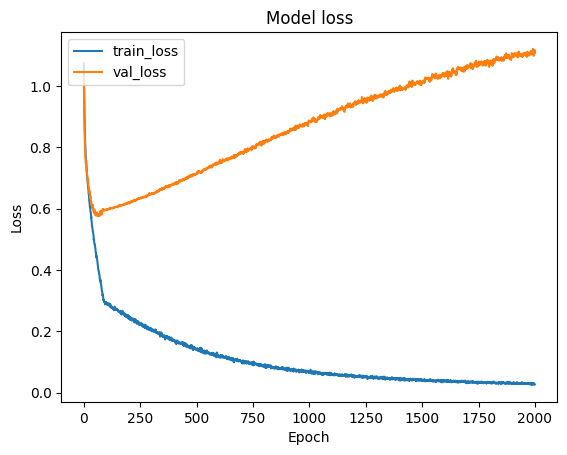

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

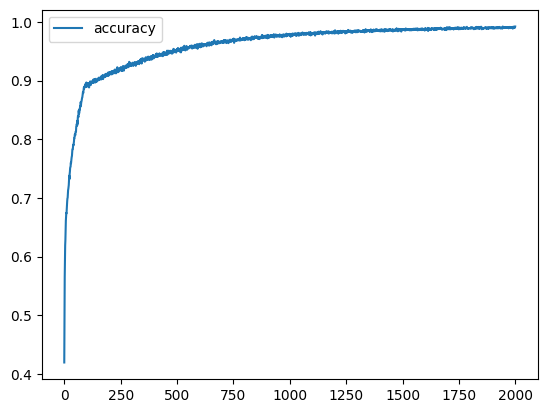

In [ ]:
plt.plot(hist.history['accuracy'])
plt.legend(['accuracy'], loc='upper left')

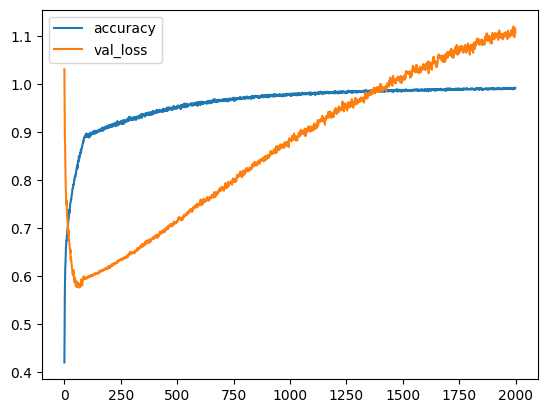

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['accuracy', 'val_loss'], loc='upper left')

# Test Animal Classification

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# bird, dog, horse
actual = np.array(
    ['Bird', 'Dog', 'Horse', 'Bird', 'Dog', 'Bird', 'Dog',  'Horse', 'Horse', 'Bird'])
predicted = np.array(
    ['Bird', 'Dog', 'Dog', 'Bird', 'Dog', 'Bird', 'Dog',  'Horse', 'Horse', 'Dog'])

In [ ]:
from keras.models import load_model
animal_model = load_model('./models/animal_cnn.h5')

In [ ]:
# convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test_animal, axis=1)

# get model predictions
y_predict = animal_model.predict(X_test_final)

# convert predictions to integers
y_predict = np.argmax(y_predict, axis=1)

#rounded_labels = np.argmax(y_test, axis=1) # convert label to single-digit

cm = confusion_matrix(y_true, y_predict)
print("Confusion Matrix and Performance of Model Architecture")
print("Model trained with images of 3 classes with input size of 15x15 and 1 channel.\n")
target_names = ['Bird', 'Dog', 'Horse']
print(classification_report(y_true, y_predict, target_names=target_names))


94/94 [==============================] - 0s 2ms/step
Confusion Matrix and Performance of Model Architecture
Model trained with images of 3 classes with input size of 15x15 and 1 channel.

              precision    recall  f1-score   support

        Bird       0.76      0.78      0.77      1000
         Dog       0.74      0.75      0.74      1000
       Horse       0.82      0.78      0.80      1000

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



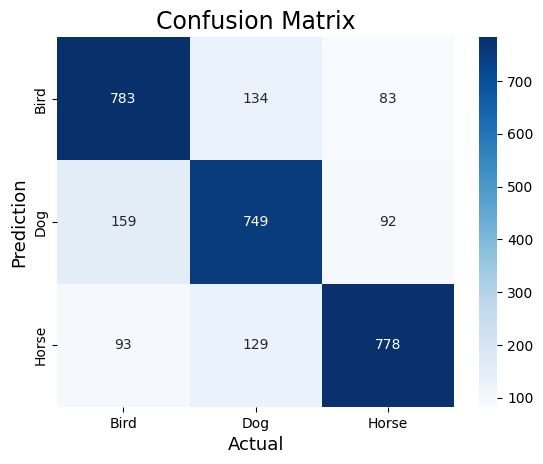

[[783 134  83]
 [159 749  92]
 [ 93 129 778]]


In [ ]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap="Blues",
            xticklabels=['Bird', 'Dog', 'Horse'],
            yticklabels=['Bird', 'Dog', 'Horse'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

print(cm)

# Test Animal Classification with Financial Model

In [ ]:
!ls

'1) Process Stock Data.ipynb'	    model.png
'2) Label Stock Data.ipynb'	    models
'3) Calculate Initial Indicators'  'Stock CNN 2k'
'4) Original Stock CNN.ipynb'	   'Stock CNN 2k Intersected Features'
'5) Feature Selection'		   'Stock CNN 2k K Best Features'
 Animals			   "Stock CNN 2k K Best Features Paper's Architecture"
'archived implementations'	   "Stock CNN 2k Paper's Architecture"
 Backtester			   'Stock CNN 3k'
 data				    ta-lib
'Expand Indicators'		    ta-lib-0.4.0-src.tar.gz


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# bird, dog, horse
actual = np.array(
    ['Bird', 'Dog', 'Horse', 'Bird', 'Dog', 'Bird', 'Dog',  'Horse', 'Horse', 'Bird'])
predicted = np.array(
    ['Bird', 'Dog', 'Dog', 'Bird', 'Dog', 'Bird', 'Dog',  'Horse', 'Horse', 'Dog'])

In [ ]:
from keras.models import load_model
financial_model = load_model('./models/stock_cnn_best_model_old_intersected_features_new_arch.h5')

In [ ]:
# convert one-hot encoded labels to integer labels
y_true = np.argmax(y_test_animal, axis=1)

# get model predictions
y_predict = financial_model.predict(X_test_final)

# convert predictions to integers
y_predict = np.argmax(y_predict, axis=1)

#rounded_labels = np.argmax(y_test, axis=1) # convert label to single-digit

cm = confusion_matrix(y_true, y_predict)
print("Confusion Matrix and Performance of Finance Model")
print("Model trained with financial images created using stock indicators.\n")
target_names = ['Bird', 'Dog', 'Horse']
print(classification_report(y_true, y_predict, target_names=target_names))


94/94 [==============================] - 1s 5ms/step
Confusion Matrix and Performance of Finance Model
Model trained with financial images created using stock indicators.

              precision    recall  f1-score   support

        Bird       0.25      0.20      0.22      1000
         Dog       0.00      0.00      0.00      1000
       Horse       0.35      0.76      0.48      1000

    accuracy                           0.32      3000
   macro avg       0.20      0.32      0.23      3000
weighted avg       0.20      0.32      0.23      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


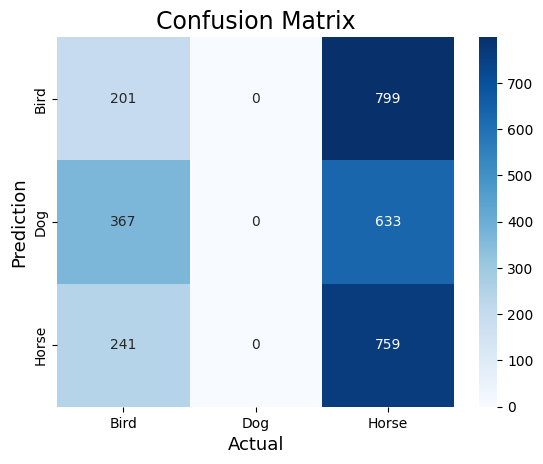

In [ ]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap="Blues",
            xticklabels=['Bird', 'Dog', 'Horse'],
            yticklabels=['Bird', 'Dog', 'Horse'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()